# Imports

In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

from sindy_core import SINDyModel, SINDyConfig
from derivatives import (  # 👈 new
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)
from systems import LorenzDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,
    plot_time_series_comparison,
    plot_3d_comparison,
    plot_error_time_series,
)
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

import jax.numpy as jnp
from systems import DuffingDefinition
from sindy_core import SINDyConfig
from run_model import run_all_for_problem

# --- build the Duffing problem with your usual parameters ---

theta = jnp.array([1.0, 5.0, 0.37, 0.1, 1.0])
params = dict(
    alpha=float(theta[0]),
    beta=float(theta[1]),
    gamma=float(theta[2]),
    delta=float(theta[3]),
    omega=float(theta[4]),
)

duffing = DuffingDefinition(
    parameters=params,
    x0_vector=jnp.array([1.0, 0.0]),
    t0=0.0,
    tf=50.0,
    dt=0.01,
)

cfg_duff = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    var_names=("x", "v"),
    mode="polynomial_and_fourier",
    k_max=3,
    include_sin=True,
    include_cos=True,
    fourier_prefix="t",
)

# --- batch all derivative/noise combinations for Duffing ---

run_all_for_problem(
    problem=duffing,
    sindy_config=cfg_duff,
    out_root="../outputs",
    drop_transient=10.0,  # keep only t > 10 for fitting, as before
)

Saved: ../outputs\Duffing\Duffing_fd_noise0.000.npz
Saved: ../outputs\Duffing\Duffing_fd_noise0.010.npz
Saved: ../outputs\Duffing\Duffing_sg_noise0.000.npz
Saved: ../outputs\Duffing\Duffing_sg_noise0.010.npz
Saved: ../outputs\Duffing\Duffing_tv_noise0.000.npz
Saved: ../outputs\Duffing\Duffing_tv_noise0.010.npz


Duffing (fd, noise=0.010)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999842*v
dv/dt = -1.00024*x - 0.099007*v - 4.98413*x^3 + 0.368653*cos(1t)


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


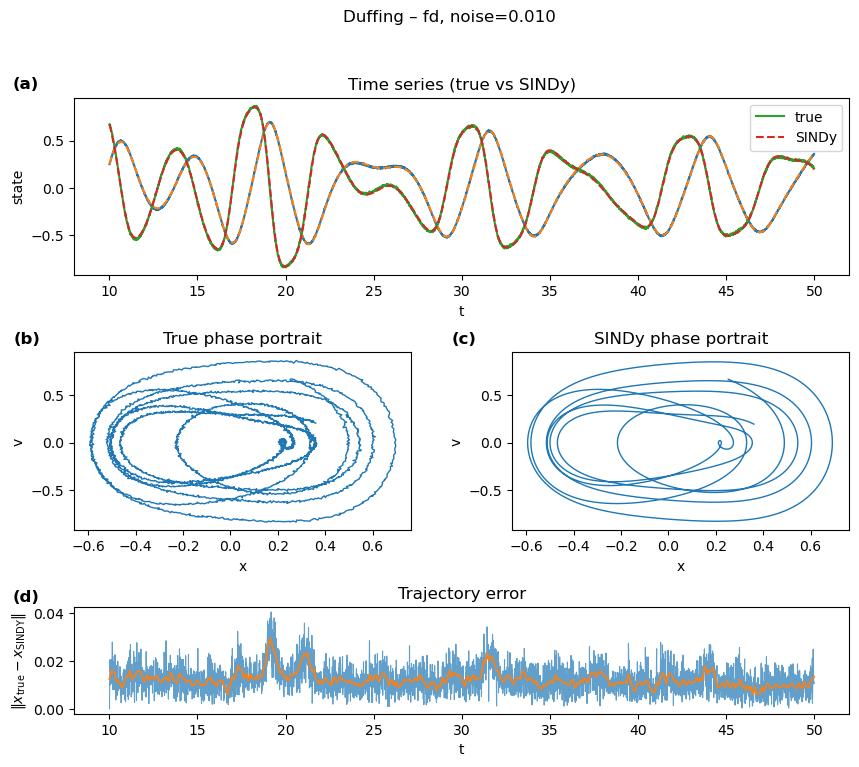

In [2]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs/Duffing/Duffing_fd_noise0.010.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")

In [2]:
import sys, os

sys.path.append(os.path.join("..", "src"))

import jax.numpy as jnp
from systems import DuffingDefinition
from sindy_core import SINDyConfig
from run_model import run_all_for_problem

# --- build the Duffing problem with your usual parameters ---

theta = jnp.array([1.0, 5.0, 0.37, 0.1, 1.0])
params = dict(
    alpha=float(theta[0]),
    beta=float(theta[1]),
    gamma=float(theta[2]),
    delta=float(theta[3]),
    omega=float(theta[4]),
)

duffing = DuffingDefinition(
    parameters=params,
    x0_vector=jnp.array([1.0, 0.0]),
    t0=0.0,
    tf=50.0,
    dt=0.01,
)

# --- config using pruned STLSQ backend ---

cfg_duff_pruned = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    var_names=("x", "v"),
    mode="polynomial_and_fourier",
    k_max=3,
    include_sin=True,
    include_cos=True,
    fourier_prefix="t",
    stlsq_mode="pruned",  # <--- key change
)

# --- batch all derivative/noise combinations for Duffing ---

run_all_for_problem(
    problem=duffing,
    sindy_config=cfg_duff_pruned,
    out_root="../outputs_pruned",  # maybe separate folder for comparison
    drop_transient=10.0,  # keep only t > 10 for fitting, as before
)

Saved: ../outputs_pruned\Duffing\Duffing_fd_noise0.000.npz
Saved: ../outputs_pruned\Duffing\Duffing_fd_noise0.010.npz
Saved: ../outputs_pruned\Duffing\Duffing_sg_noise0.000.npz
Saved: ../outputs_pruned\Duffing\Duffing_sg_noise0.010.npz
Saved: ../outputs_pruned\Duffing\Duffing_tv_noise0.000.npz
Saved: ../outputs_pruned\Duffing\Duffing_tv_noise0.010.npz


Duffing (fd, noise=0.000)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999968*v
dv/dt = -1.00011*x - 0.0999941*v - 4.99909*x^3 + 0.369979*cos(1t)


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


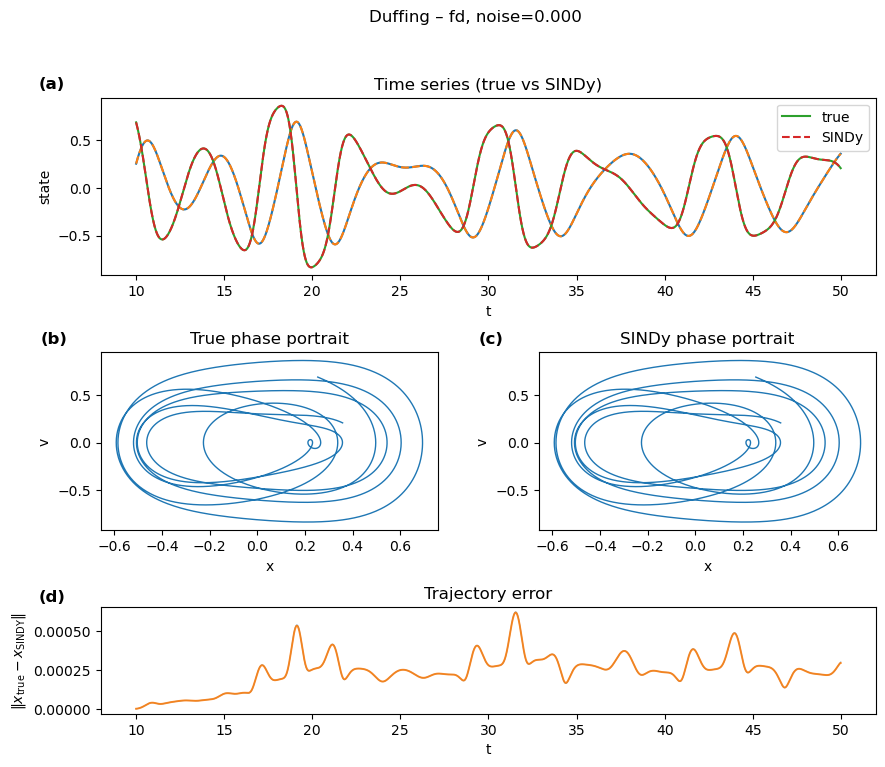

In [3]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs_pruned/Duffing/Duffing_fd_noise0.000.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")

Duffing (fd, noise=0.010)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999844*v
dv/dt = -1.00024*x - 0.0990069*v - 4.98414*x^3 + 0.368652*cos(1t)


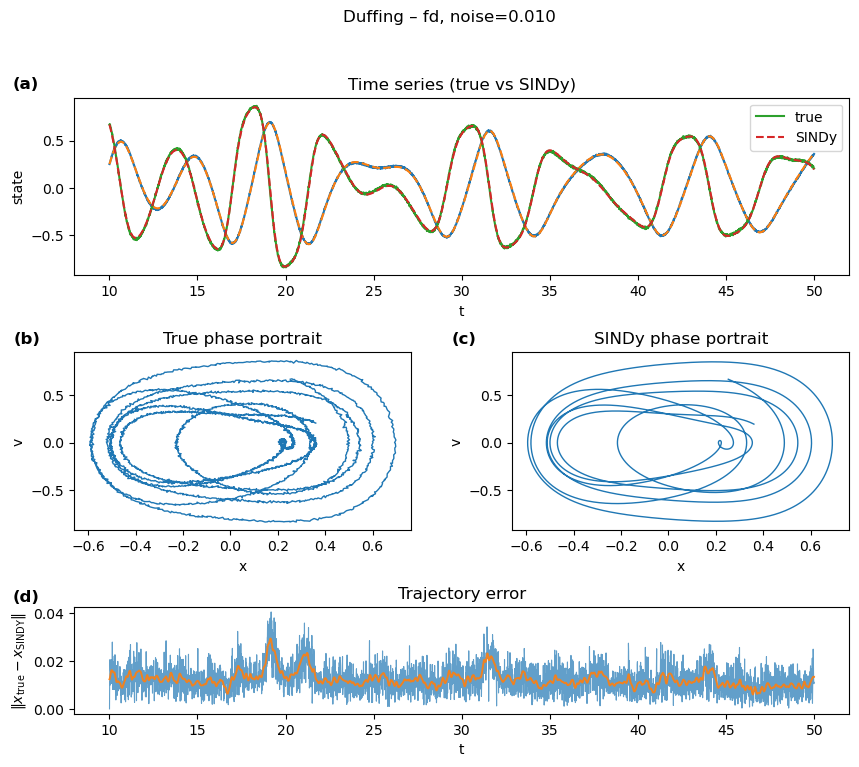

In [4]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs_pruned/Duffing/Duffing_fd_noise0.010.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")

Duffing (sg, noise=0.000)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999998*v
dv/dt = -1.00004*x - 0.1*v - 4.99981*x^3 + 0.369999*cos(1t)


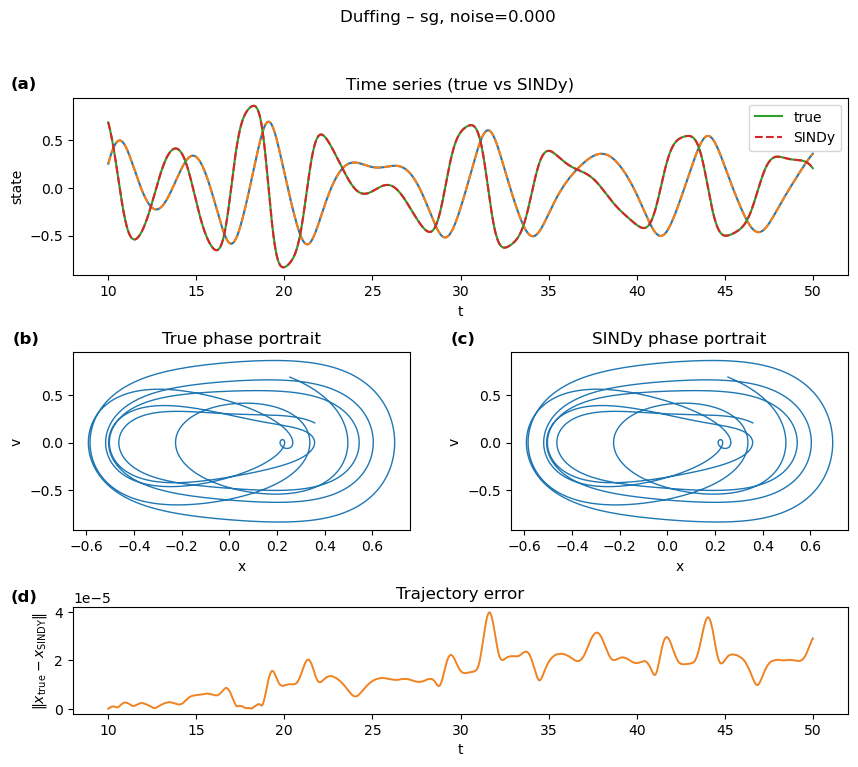

In [5]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs_pruned/Duffing/Duffing_sg_noise0.000.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")

Duffing (sg, noise=0.010)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999653*v
dv/dt = -1.00026*x - 0.0992597*v - 4.98409*x^3 + 0.368737*cos(1t)


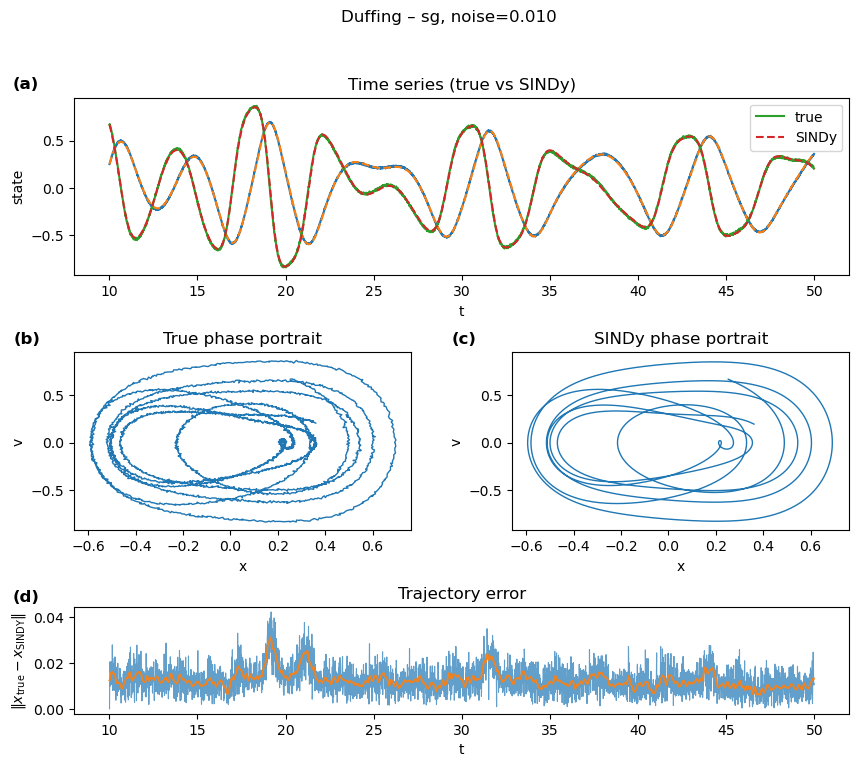

In [6]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs_pruned/Duffing/Duffing_sg_noise0.010.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")

Duffing (tv, noise=0.000)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 1.00286*v + 0.0348181*x^3 - 0.0110541*v^3
dv/dt = -0.996022*x - 0.0964662*v - 4.98744*x^3 + 0.0840837*x^2 v - 0.0325593*x v^2 + 0.369288*cos(1t)


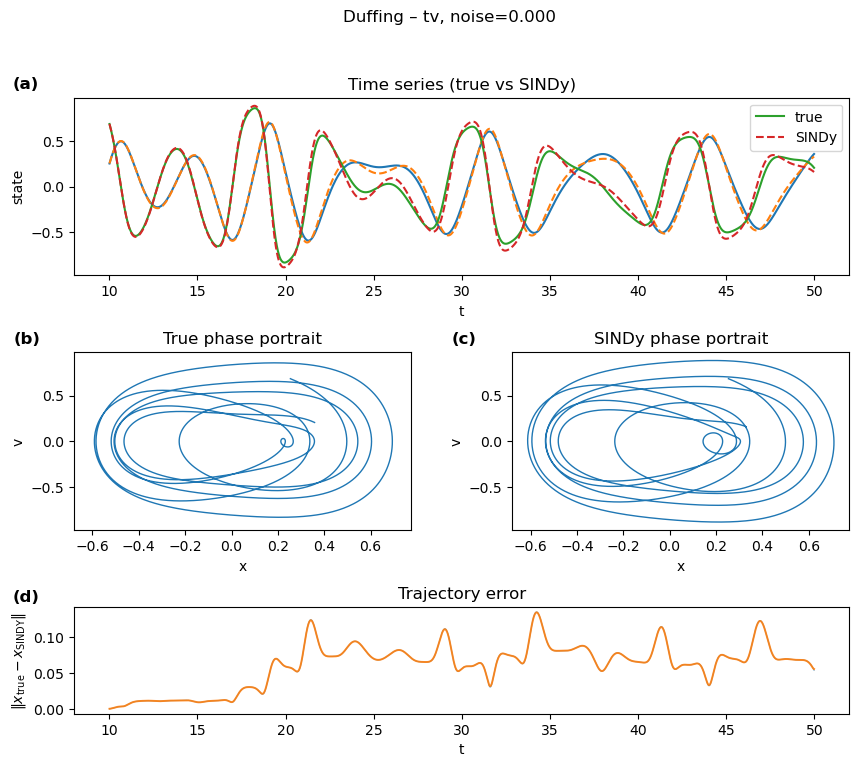

In [7]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs_pruned/Duffing/Duffing_tv_noise0.000.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")

Duffing (tv, noise=0.010)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 1.0027*v + 0.0351903*x^3 - 0.012656*v^3
dv/dt = -0.998911*x - 0.0961534*v - 4.96744*x^3 + 0.0804591*x^2 v - 0.0307619*x v^2 + 0.36888*cos(1t)


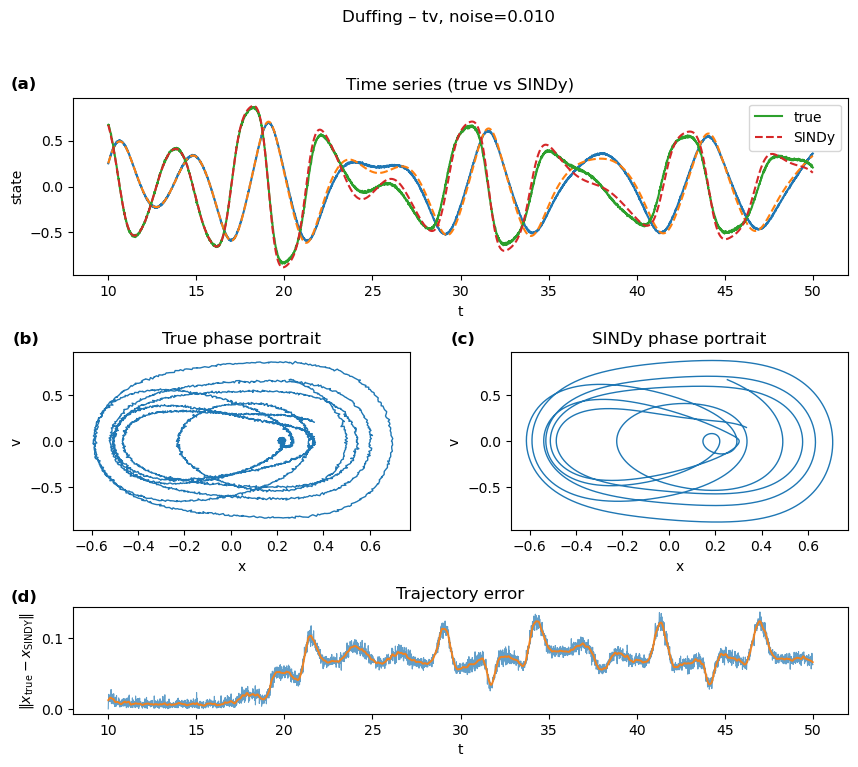

In [8]:
from run_model import (
    load_experiment,
    make_composite_figure,
    print_equations_from_result,  # or print_equation_summary if you kept that name
)

path = "../outputs_pruned/Duffing/Duffing_tv_noise0.010.npz"
result = load_experiment(path)

print_equations_from_result(result)

fig, axes = make_composite_figure(
    result,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig.savefig("duffing_fd_noise001_composite.png", dpi=300, bbox_inches="tight")